In [4]:
from google.colab import files
uploaded=files.upload()

Saving botswana_bank_customer_churn.csv to botswana_bank_customer_churn.csv


DATA PREPARATION

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np

# Load dataset
df = pd.read_csv("botswana_bank_customer_churn.csv")

# 1. Remove irrelevant columns
columns_to_drop = ['CustomerId', 'Name', 'Address']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# 2. Convert 'Date of Birth' to 'Age'
if 'Date of Birth' in df.columns:
    df['Date of Birth'] = pd.to_datetime(df['Date of Birth'], errors='coerce')
    current_year = pd.Timestamp.now().year
    df['Age'] = current_year - df['Date of Birth'].dt.year
    df.drop(columns=['Date of Birth'], inplace=True)

# 3. Handle missing values in churn-specific fields conditionally
churn_specific_fields = ['Churn', 'LastTransactionDate', 'Balance']
for field in churn_specific_fields:
    if field in df.columns:
        if df[field].dtype == 'object':
            df[field] = df[field].fillna('Unknown')
        else:
            df[field] = df[field].fillna(df[field].median())

# 4. Encode categorical features efficiently
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
label_encoder = LabelEncoder()
high_cardinality_threshold = 50

for col in categorical_cols:
    num_unique = df[col].nunique()
    if num_unique <= 2 or num_unique > high_cardinality_threshold:
        df[col] = label_encoder.fit_transform(df[col].astype(str))
    else:
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df.drop(columns=[col]), dummies], axis=1)

# 5. Normalize numeric columns using MinMaxScaler
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Preview the processed data
print(df.head())

   RowNumber   Surname  First Name  Gender  Number of Dependents  Occupation  \
0   0.000000  0.857858    0.957910     1.0                   0.6    0.498433   
1   0.000009  0.886887    0.544267     0.0                   0.2    0.131661   
2   0.000017  0.318318    0.404935     0.0                   0.2    0.935737   
3   0.000026  0.993994    0.065312     0.0                   1.0    0.040752   
4   0.000035  0.013013    0.494920     0.0                   0.4    0.916928   

     Income  Contact Information  Customer Tenure  \
0  0.765371             0.381800         1.000000   
1  0.560102             0.278358         0.896552   
2  0.050454             0.985783         0.448276   
3  0.106191             0.347028         0.758621   
4  0.586594             0.524953         0.724138   

   Preferred Communication Channel  ...  Education Level_Diploma  \
0                              1.0  ...                    False   
1                              0.0  ...                    False

EXPLORATORY DATE ANALYSIS (EDA)

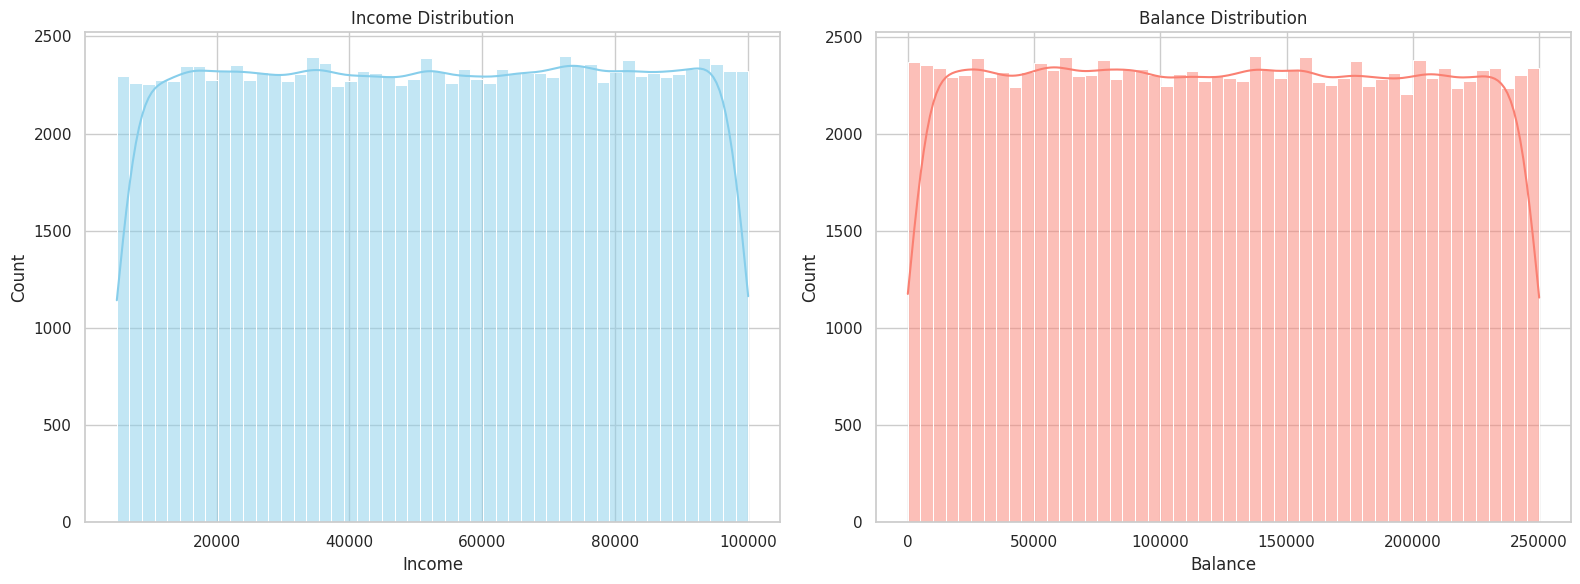

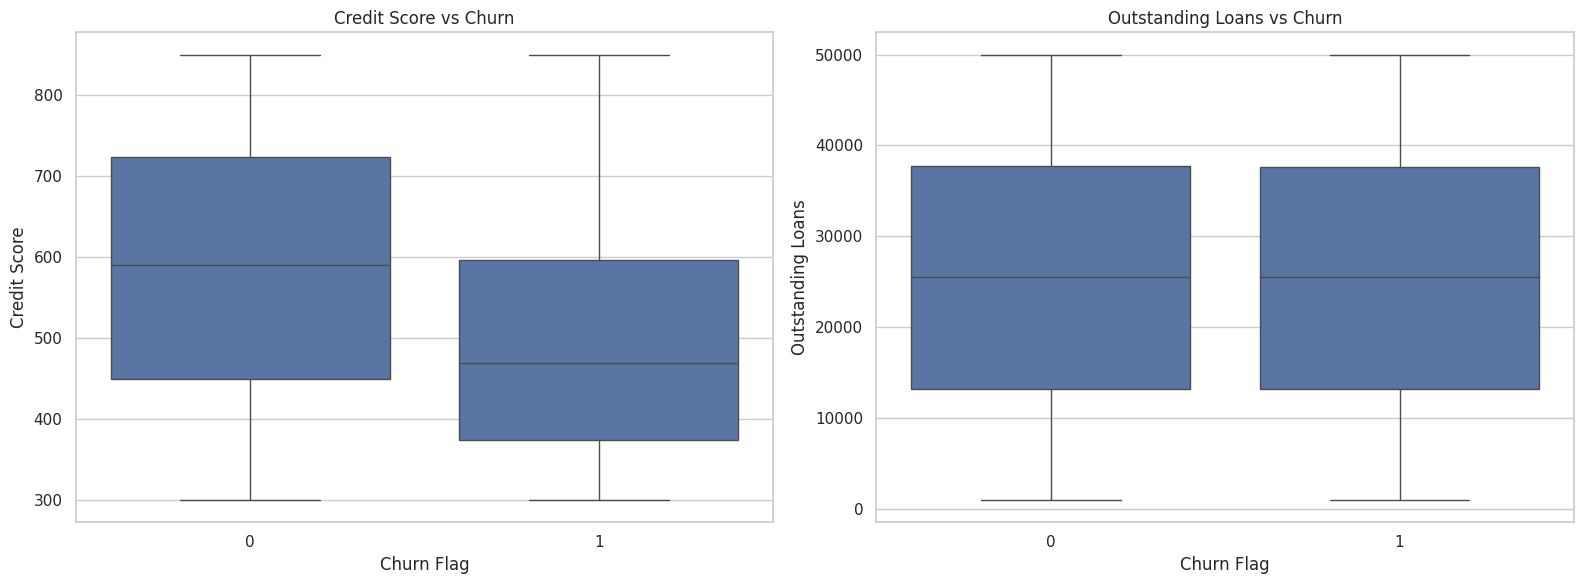

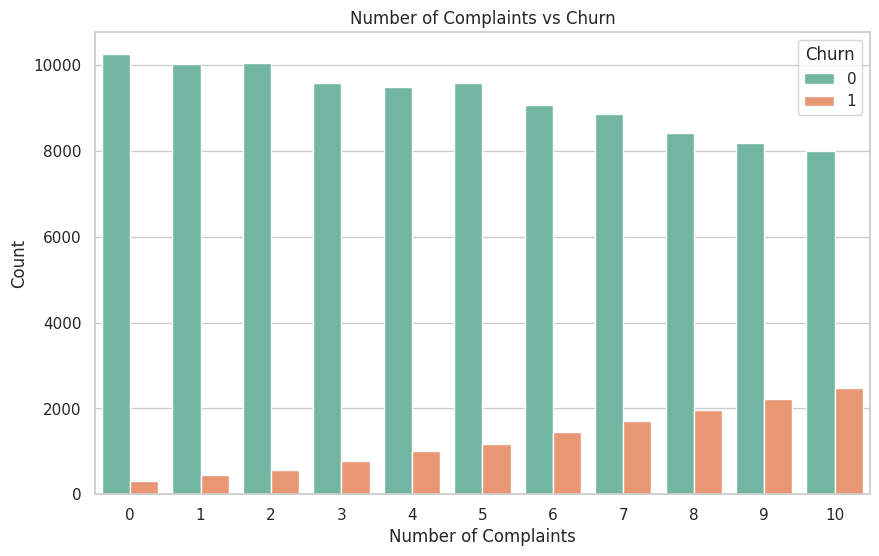

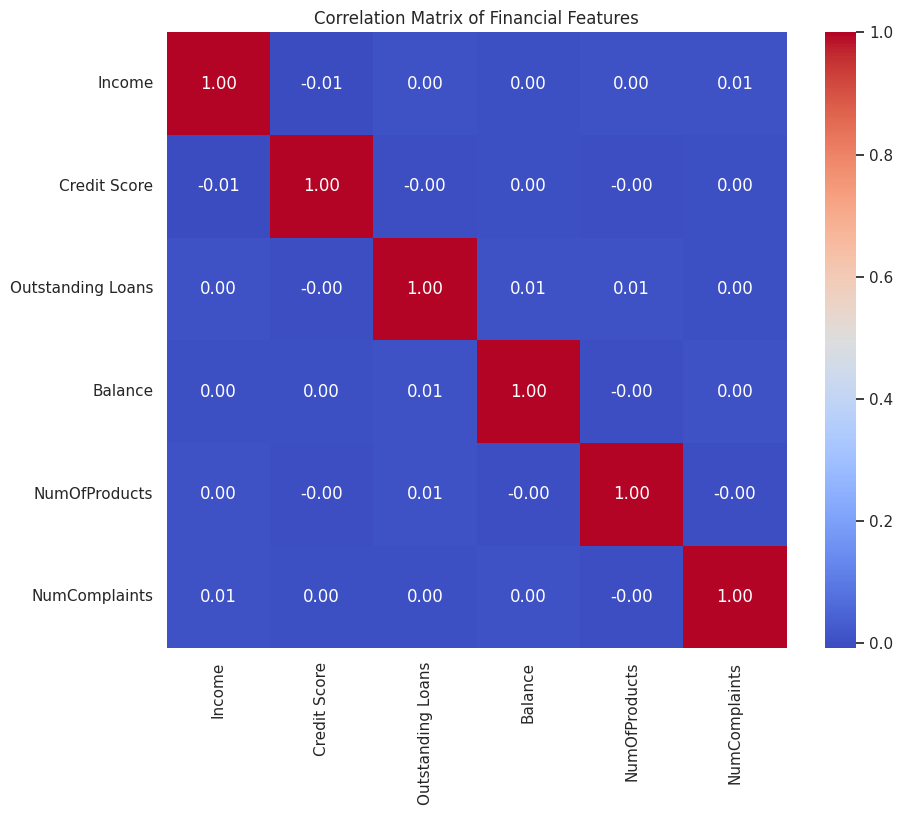

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('botswana_bank_customer_churn.csv')

# Convert relevant columns to numeric
df['Credit Score'] = pd.to_numeric(df['Credit Score'], errors='coerce')

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Histogram for Income and Balance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df['Income'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Income Distribution')
sns.histplot(df['Balance'], bins=50, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Balance Distribution')
plt.tight_layout()
plt.show()

# Boxplots for Credit Score and Outstanding Loans vs Churn
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(x='Churn Flag', y='Credit Score', data=df, ax=axes[0])
axes[0].set_title('Credit Score vs Churn')
sns.boxplot(x='Churn Flag', y='Outstanding Loans', data=df, ax=axes[1])
axes[1].set_title('Outstanding Loans vs Churn')
plt.tight_layout()
plt.show()

# Countplot: Number of Complaints vs Churn
plt.figure(figsize=(10, 6))
sns.countplot(x='NumComplaints', hue='Churn Flag', data=df, palette='Set2')
plt.title('Number of Complaints vs Churn')
plt.xlabel('Number of Complaints')
plt.ylabel('Count')
plt.legend(title='Churn')
plt.show()

# Correlation Heatmap
financial_cols = ['Income', 'Credit Score', 'Outstanding Loans', 'Balance', 'NumOfProducts', 'NumComplaints']
corr_matrix = df[financial_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Financial Features')
plt.show()

FEATURE ENGINEERING

In [19]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder


# --- Feature Engineering ---

# 1. Create 'Age' from 'Date of Birth'
df['Date of Birth'] = pd.to_datetime(df['Date of Birth'], errors='coerce')
df['Age'] = 2025 - df['Date of Birth'].dt.year

# 2. Bin 'Customer Tenure' into categories
def tenure_category(tenure):
    if tenure < 5:
        return 'Short'
    elif tenure < 10:
        return 'Medium'
    else:
        return 'Long'

df['TenureCategory'] = df['Customer Tenure'].apply(tenure_category)

# 3. Drop high-cardinality or low-variance columns
high_card_cols = ['CustomerId', 'Surname', 'First Name', 'Address', 'Contact Information']
df.drop(columns=high_card_cols, inplace=True)

low_variance_cols = [col for col in df.columns if df[col].nunique() <= 1]
df.drop(columns=low_variance_cols, inplace=True)

# Drop datetime and churn explanation columns
df.drop(columns=['Date of Birth', 'Churn Reason', 'Churn Date'], inplace=True)

# 4. Encode categorical variables
df_encoded = df.copy()
le = LabelEncoder()
cat_cols = df_encoded.select_dtypes(include='object').columns

for col in cat_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# --- Feature Selection ---

# Define features and target
X = df_encoded.drop(columns=['Churn Flag'])
y = df_encoded['Churn Flag']

# Fit Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10)

# Display top features
print("Top 10 Important Features for Churn Prediction:")
print(top_features)

Top 10 Important Features for Churn Prediction:
Balance                  0.552171
NumComplaints            0.113207
Credit Score             0.103970
NumOfProducts            0.083633
RowNumber                0.018985
Outstanding Loans        0.018916
Income                   0.018597
Occupation               0.018098
Age                      0.015436
Credit History Length    0.013518
dtype: float64


MODEL BUILDING

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Drop unnecessary columns
# We use errors='ignore' to avoid KeyError if a column is already dropped
columns_to_drop_model = [
    'RowNumber',
    'CustomerId',
    'Surname',
    'First Name',
    'Date of Birth',
    'Address',
    'Contact Information',
    'Churn Reason',
    'Churn Date'
]
df = df.drop(columns=columns_to_drop_model, errors='ignore')


# Drop rows with missing values if any (optional: imputation could be done too)
df = df.dropna()

# Encode categorical features
categorical_cols = df.select_dtypes(include='object').columns
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col, le in label_encoders.items():
    df[col] = le.fit_transform(df[col])

# Features and target
X = df.drop('Churn Flag', axis=1)
y = df['Churn Flag']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Evaluation
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_log))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log))

print("\nRandom Forest Classifier Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20301
           1       1.00      1.00      1.00      2827

    accuracy                           1.00     23128
   macro avg       1.00      1.00      1.00     23128
weighted avg       1.00      1.00      1.00     23128

Confusion Matrix:
[[20298     3]
 [   11  2816]]

Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     20301
           1       0.98      0.92      0.95      2827

    accuracy                           0.99     23128
   macro avg       0.99      0.96      0.97     23128
weighted avg       0.99      0.99      0.99     23128

Confusion Matrix:
[[20250    51]
 [  216  2611]]


MODEL EVALUATION

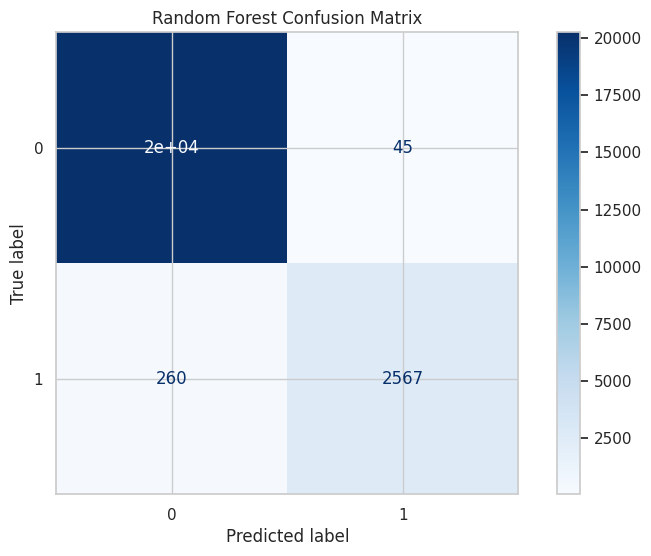

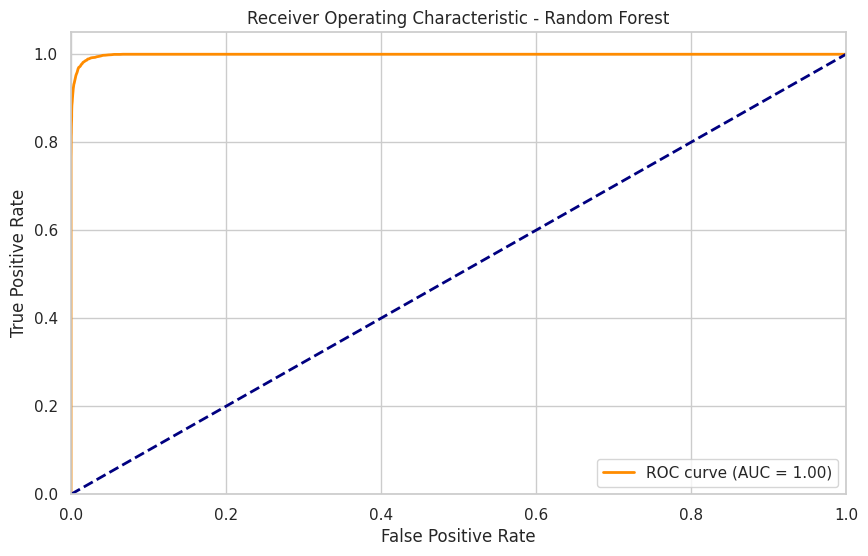

Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     20301
           1       0.98      0.91      0.94      2827

    accuracy                           0.99     23128
   macro avg       0.99      0.95      0.97     23128
weighted avg       0.99      0.99      0.99     23128



In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("botswana_bank_customer_churn.csv")

# Drop irrelevant columns
df = df.drop(columns=[
    'RowNumber', 'CustomerId', 'Surname', 'First Name', 'Date of Birth',
    'Address', 'Contact Information', 'Churn Reason', 'Churn Date'
])

# Drop rows with missing values
df = df.dropna()

# Encode categorical variables
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Define features and target
X = df.drop('Churn Flag', axis=1)
y = df['Churn Flag']

# Scale features
X = StandardScaler().fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic - Random Forest")
plt.legend(loc="lower right")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

DEPLOYMENT

In [27]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.4 MB/s eta 0:00:00


In [28]:
# streamlit_app.py

import streamlit as st
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Load and prepare the data
df = pd.read_csv("botswana_bank_customer_churn.csv")
df = df.drop(columns=[
    'RowNumber', 'CustomerId', 'Surname', 'First Name', 'Date of Birth',
    'Address', 'Contact Information', 'Churn Reason', 'Churn Date'
])
df = df.dropna()

# Encode categorical features
categorical_cols = df.select_dtypes(include='object').columns
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# Prepare features and target
X = df.drop('Churn Flag', axis=1)
y = df['Churn Flag']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_scaled, y)

# Streamlit App
st.title("Botswana Bank Customer Churn Prediction")

# User inputs
user_input = {}
for col in X.columns:
    if col in categorical_cols:
        options = list(encoders[col].classes_)
        selection = st.selectbox(f"{col}", options)
        user_input[col] = encoders[col].transform([selection])[0]
    else:
        user_input[col] = st.number_input(f"{col}", value=float(df[col].mean()))

# Prediction
if st.button("Predict"):
    input_df = pd.DataFrame([user_input])
    input_scaled = scaler.transform(input_df)
    prediction = model.predict(input_scaled)[0]
    result = "Customer is likely to churn." if prediction == 1 else "Customer is likely to stay."
    st.success(result)

2025-05-14 17:04:40.514 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 17:04:40.629 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-05-14 17:04:40.630 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 17:04:40.632 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 17:04:40.633 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 17:04:40.634 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 17:04:40.635 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 17:04:40.636 Session state does not 